In [125]:
# Ιωάννης Χουλιάρας --- AM: 2631
# Παρουσίαση πρώτου ερωτήματος της τελικής εργασίας στο μάθημα επιλογής Υπολογιστική Όραση.

In [97]:
import tensorflow as tf
import os
import sys
import tarfile
import tempfile
import cv2
from six.moves import urllib
import numpy as np
from PIL import Image, ImageDraw, ImageFont
from matplotlib import pyplot as plt

In [98]:
#Η έκδοση του tensorflow && της python:
print('tensorflow: ' + tf.__version__)
print('Python: ' + sys.version)

tensorflow: 1.8.0
Python: 3.6.10 |Anaconda, Inc.| (default, May  7 2020, 23:06:31) 
[GCC 4.2.1 Compatible Clang 4.0.1 (tags/RELEASE_401/final)]


In [99]:
global MODEL
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # removes annoying warning.

In [100]:
#pure copy from deeplab_demo.ipynb
class DeepLabModel(object):
    """Class to load deeplab model and run inference."""

    INPUT_TENSOR_NAME = 'ImageTensor:0'
    OUTPUT_TENSOR_NAME = 'SemanticPredictions:0'
    INPUT_SIZE = 513
    FROZEN_GRAPH_NAME = 'frozen_inference_graph'

    def __init__(self, tarball_path):
        """Creates and loads pretrained deeplab model."""
        self.graph = tf.Graph()

        graph_def = None
        # Extract frozen graph from tar archive.
        tar_file = tarfile.open(tarball_path)
        for tar_info in tar_file.getmembers():
            if self.FROZEN_GRAPH_NAME in os.path.basename(tar_info.name):
                file_handle = tar_file.extractfile(tar_info)
                graph_def = tf.GraphDef.FromString(file_handle.read())
                break

        tar_file.close()

        if graph_def is None:
            raise RuntimeError('Cannot find inference graph in tar archive.')

        with self.graph.as_default():
            tf.import_graph_def(graph_def, name='')

        self.sess = tf.Session(graph=self.graph)

    def run(self, image):
        width, height = image.size
        resize_ratio = 1.0 * self.INPUT_SIZE / max(width, height)
        target_size = (int(resize_ratio * width), int(resize_ratio * height))
        resized_image = image.convert('RGB').resize(
            target_size, Image.ANTIALIAS)
        batch_seg_map = self.sess.run(
            self.OUTPUT_TENSOR_NAME,
            feed_dict={self.INPUT_TENSOR_NAME: [np.asarray(resized_image)]})
        seg_map = batch_seg_map[0]
        return resized_image, seg_map

In [101]:
#pure copy from deeplab_demo.ipynb
def create_pascal_label_colormap():
    colormap = np.zeros((256, 3), dtype=int)
    ind = np.arange(256, dtype=int)

    for shift in reversed(range(8)):
        for channel in range(3):
            colormap[:, channel] |= ((ind >> channel) & 1) << shift
        ind >>= 3

    return colormap

In [102]:
#pure copy from deeplab_demo.ipynb
def label_to_color_image(label):
    if label.ndim != 2:
        raise ValueError('Expect 2-D input label')

    colormap = create_pascal_label_colormap()

    if np.max(label) >= len(colormap):
        raise ValueError('label value too large.')

    return colormap[label]


In [103]:
def vis_segmentation(image, seg_map):
    seg_image = label_to_color_image(seg_map).astype(np.uint8)
    unique_labels = np.unique(seg_map)
    colors = FULL_COLOR_MAP[unique_labels].astype(np.uint8)
    labels_names = LABEL_NAMES[unique_labels]
    return (seg_image, colors, labels_names)

In [105]:
# downloads the model. Almost a pure copy (choosed another model)
def get_model():
    global MODEL
    MODEL_NAME = 'mobilenetv2_coco_voctrainval'

    _DOWNLOAD_URL_PREFIX = 'http://download.tensorflow.org/models/'
    _MODEL_URLS = {
        'mobilenetv2_coco_voctrainaug':
            'deeplabv3_mnv2_pascal_train_aug_2018_01_29.tar.gz',
        'mobilenetv2_coco_voctrainval':
            'deeplabv3_mnv2_pascal_trainval_2018_01_29.tar.gz',
        'xception_coco_voctrainaug':
            'deeplabv3_pascal_train_aug_2018_01_04.tar.gz',
        'xception_coco_voctrainval':
            'deeplabv3_pascal_trainval_2018_01_04.tar.gz',
    }
    _TARBALL_NAME = 'deeplab_model.tar.gz'

    model_dir = tempfile.mkdtemp()
    tf.gfile.MakeDirs(model_dir)

    download_path = os.path.join(model_dir, _TARBALL_NAME)
    print('downloading model, this might take a while...')
    urllib.request.urlretrieve(_DOWNLOAD_URL_PREFIX + _MODEL_URLS[MODEL_NAME],
                               download_path)
    print('download completed! loading DeepLab model...')

    MODEL = DeepLabModel(download_path)
    print('model loaded successfully!')

In [106]:
# Εδώ δημιουργούμε τα labels στα οποία το μοντέλο μας έχει εκπαιδευτεί.

def create_labels():
    label_names = np.asarray([
        'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
        'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
        'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
    ])
    full_label_map = np.arange(len(label_names)).reshape(len(label_names), 1)
    full_color_map = label_to_color_image(full_label_map)
    return (label_names, full_label_map, full_color_map)


In [107]:
# Η συνάρτηση αυτή καλείται από την main.

def run_visualization(image_name, output_name):
    try:
        original_im = Image.open(image_name)
    except IOError:
        print('Cannot retrieve image. Please check the name')
        return
    print('running deeplab on image %s...' % image_name)
    resized_im, seg_map = MODEL.run(original_im)
    (segm_image, colors, labels) = vis_segmentation(resized_im, seg_map)
    final_image = create_final_image(segm_image, colors, labels)
    return final_image

In [108]:
# Με αυτή την συνάρτηση, δημιουργούμε την τελική φωτογραφία. Δέχεται σαν όρισμα τον πίνακα από την επεξεργασμένη
# φωτογραφία, τα χρώματα και τις ετικέτες από τα αντικείμενα που έχει αναγνωρίσει στην φωτογραφία.

def create_final_image(array_image, colors, labels):
    w_prev = 0 # κρατάει το width της προηγούμενης φωτογραφίας
    image = Image.fromarray(array_image) # ανοίγει την εικόνα
    width, height = image.size
    n_image = Image.new('RGB', (width+10, int(height+(height/5))), 'white')
    n_image.paste(image, (5, 5, (width + 5), (height+5)))
    return draw_image(n_image, colors, labels, width, height) # επιστρέφει την νέα φωτογραφία με το κείμενο στο τέλος

In [109]:
# Στην συνάρτηση αυτή, έχουμε την τελική μας εικόνα και πρέπει να προσθέσουμε το κείμενο των αντικειμένων 
# με τα κατάλληλα χρώματα! 

def draw_image(image, colors, labels, width, height):
    font = ImageFont.truetype("/Users/mac/Library/Fonts/BEBAS.ttf", 20) # επιλέγω την γραμματοσειρά
    draw = ImageDraw.Draw(image) # χρησιμοποιώ το ImageDraw για να γράψω το κείμενο
    previous_width = 0 
    for i in range(len(labels)):
        label = labels[i]
        current_w, current_h = font.getsize(label)
        if i == 0:
            draw_w = (width-current_w) # αν είσαι το αρχικό label τοποθέτησε το τέρμα δεξιά.
        else:
            draw_w = (width-current_w) - previous_width # αν όχι, τοποθέτησε το στην κατάλληλη θέση. Είναι όλα τα widths μαζί.
        draw_h = (height + ((height/5)-current_h)/2) # το κατάλληλο height 
        color = (colors[i][0][0], colors[i][0][1], colors[i][0][2]) # ποιο χρώμα για κάθε label
        draw.text((draw_w, draw_h), label, font=font, fill=color) # γράψε το text για κάθε label.
        previous_width += current_w # πρόσθεσε το width στο σύνολο των widths
    return image

In [110]:
# Η main στην ουσία θα δεχθεί δύο ορίσματα, το πρώτο είναι η ονομασία της κανονικής φωτογραφίας, ενώ το δεύτερο
# όρισμα θα είναι η ονομασία της τελικής φωτογραφίας.
name_1 = 'office.jpg'
name_2 = 'city.jpg'
name_3 = 'dining.jpg'
name_4 = 'horse_man.jpg'
name_5 = 'plane_train.jpg'
output_name = 'no_need_here.jpg' # δεν χρειάζεται καθώς δεν θα γίνει save

(LABEL_NAMES, FULL_LABEL_MAP, FULL_COLOR_MAP) = create_labels() # δημιουργία των labels
get_model() # κατεβάζουμε το MODEL. ('mobilenetv2_coco_voctrainval')

downloading model, this might take a while...
download completed! loading DeepLab model...
model loaded successfully!


In [111]:
# Θα τρέξω και για τις πέντε φωτογραφίες την συνάρτηση run_visualization
output_image_1 = run_visualization(name_1, output_name)
output_image_2 = run_visualization(name_2, output_name)
output_image_3 = run_visualization(name_3, output_name)
output_image_4 = run_visualization(name_4, output_name)
output_image_5 = run_visualization(name_5, output_name)

running deeplab on image office.jpg...
running deeplab on image city.jpg...
running deeplab on image dining.jpg...
running deeplab on image horse_man.jpg...
running deeplab on image plane_train.jpg...


In [119]:
# Φορτώνω και τις original φωτογραφίες: 
input_image_1 = cv2.imread(name_1)
input_image_2 = cv2.imread(name_2)
input_image_3 = cv2.imread(name_3)
input_image_4 = cv2.imread(name_4)
input_image_5 = cv2.imread(name_5)
print('done...')

done...


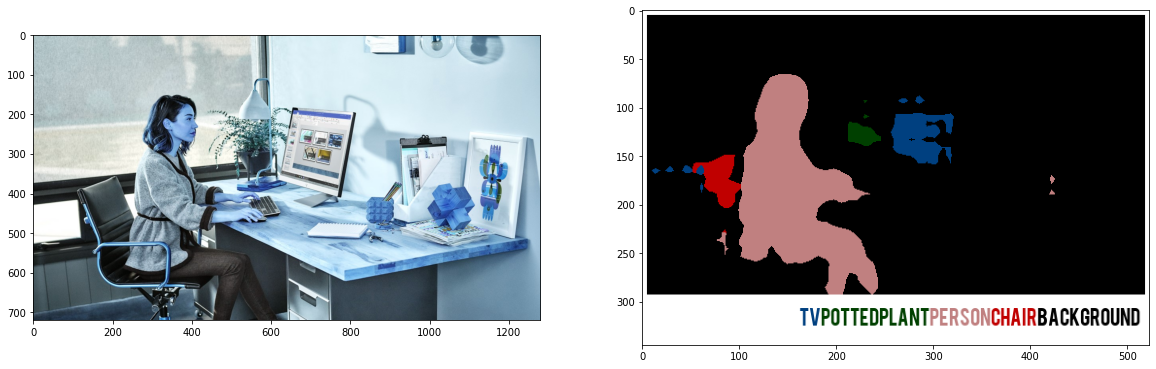

In [120]:
# Παρακάτω παρουσιάζεται το αποτέλεσμα για τις πέντε διαφορετικές φωτογραφίες.

fig = plt.figure(figsize=(20,20))
plt.subplot(1, 2, 1)
plt.imshow(input_image_1)
plt.subplot(1, 2, 2)
plt.imshow(output_image_1)
plt.show()

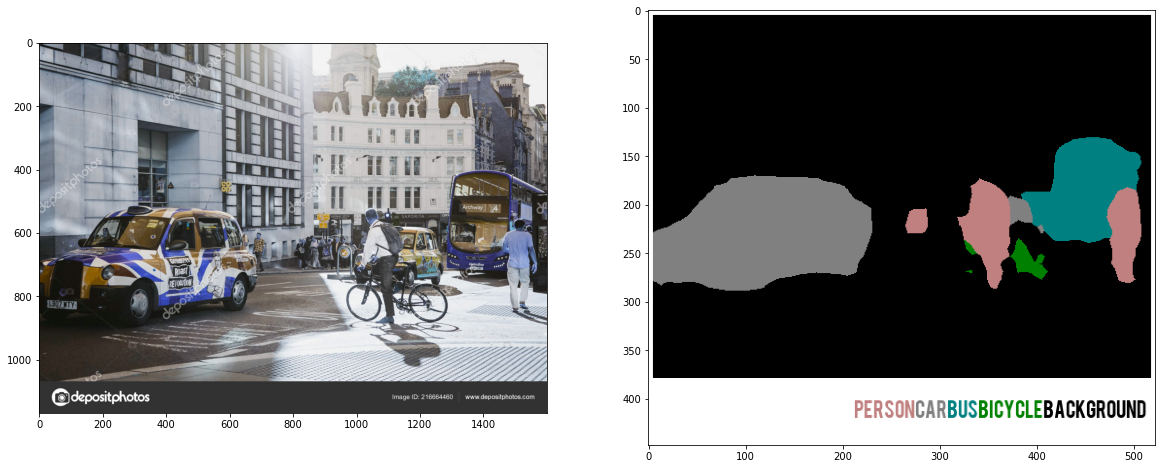

In [121]:
fig = plt.figure(figsize=(20,20))
plt.subplot(1, 2, 1)
plt.imshow(input_image_2)
plt.subplot(1, 2, 2)
plt.imshow(output_image_2)
plt.show()

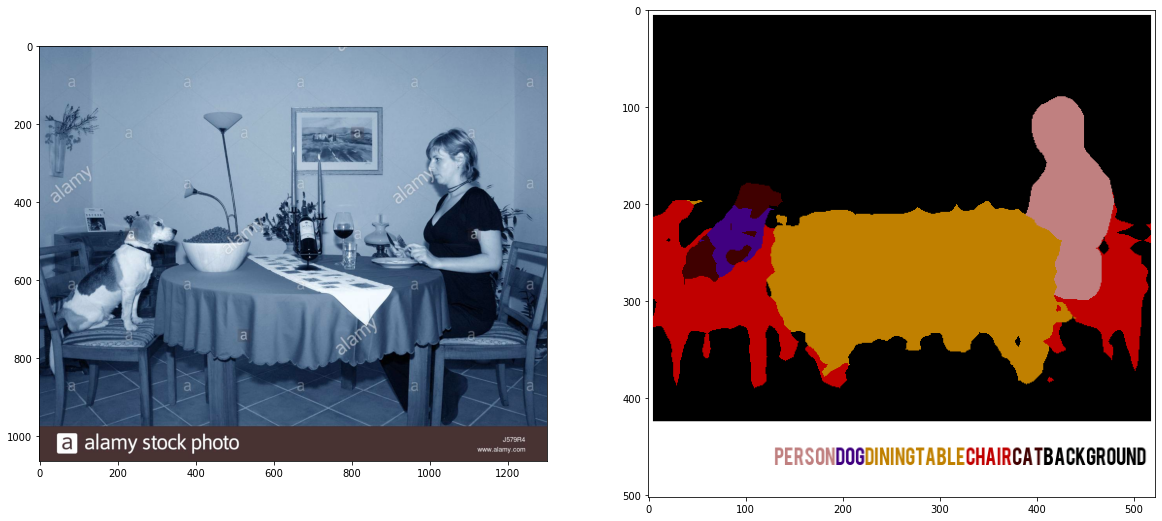

In [122]:
fig = plt.figure(figsize=(20,20))
plt.subplot(1, 2, 1)
plt.imshow(input_image_3)
plt.subplot(1, 2, 2)
plt.imshow(output_image_3)
plt.show()

# Εδώ υπάρχει και μία αστοχία, καθώς αναγνωρίζει γάτα ενώ δεν υπάρχει.

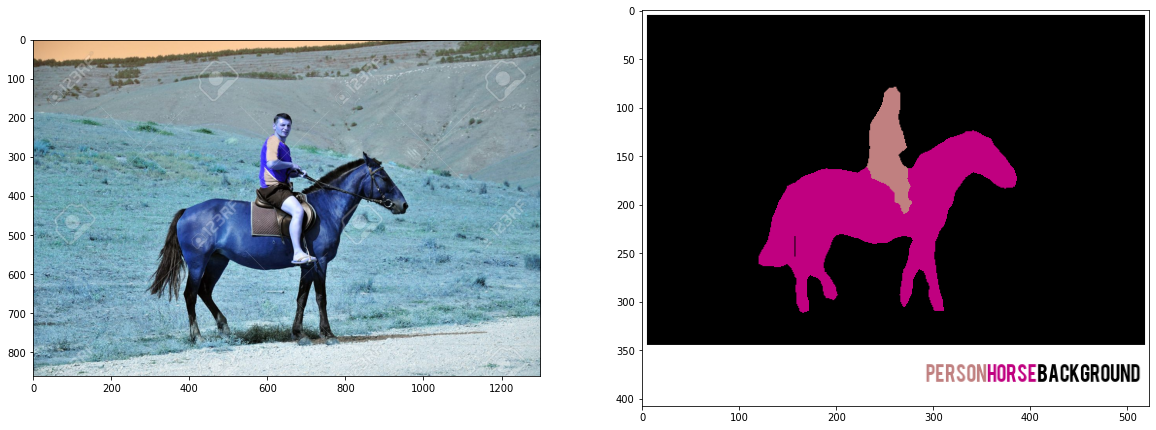

In [123]:
fig = plt.figure(figsize=(20,20))
plt.subplot(1, 2, 1)
plt.imshow(input_image_4)
plt.subplot(1, 2, 2)
plt.imshow(output_image_4)
plt.show()


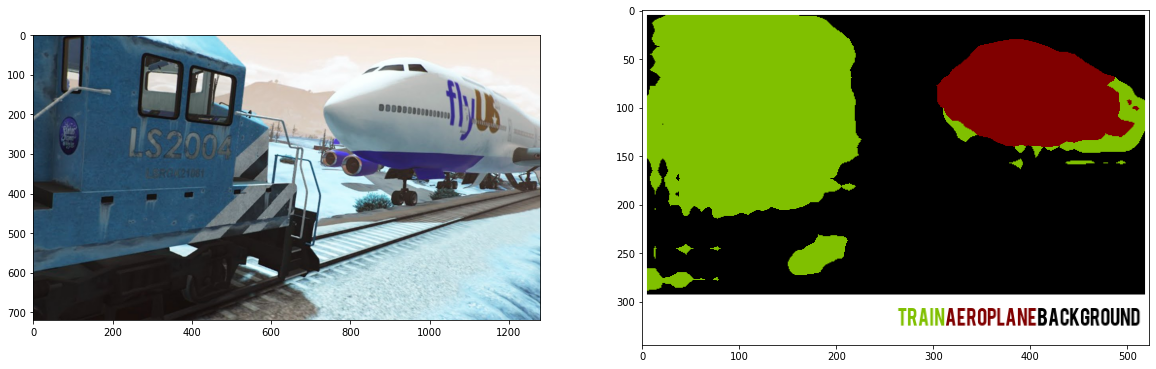

In [124]:
fig = plt.figure(figsize=(20,20))
plt.subplot(1, 2, 1)
plt.imshow(input_image_5)
plt.subplot(1, 2, 2)
plt.imshow(output_image_5)
plt.show()

